In [141]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio

from IPython.display import Audio

def load_flac(path):
    waveform, sample_rate = torchaudio.load(path)
    return waveform[0].numpy(), sample_rate 

# Module 1

## Lecture 1

### **1**

Let's consider a waveform, which represents different sounds:

![](./images/3-s2.0-B9780128130865000037-f05-09-9780128130865.jpg)

Can we decompose an arbitrary wave into Fourier series with high precision? - Yes, but with a very high value of N.

> <span style="color:red">**TODO**</span>: Why?

Because the Fourier series seeks to represent the input signal using a new **orthogonal basis**:

$$\left\{ 1, \cos \left( 2\pi n x \right), \sin \left( 2\pi n x \right) \right\} _{n = 1}^{\infty}$$

Since the signal is high-dimensional in the function space, the number **N** determines how many basis components we use in the approximation — similar to a **rank-N approximation in SVD**, where more components capture more structure in the original data.

Thus, using a large **N** allows capture more high-frequency components and finer details of the signal, resulting in a more precise approximation.

### **2**


But in practice having such a big N value is not reasonable because:

- We again get high resolution data.
- It is an "overfit".

Let's consider an alternative approach. One way to simplify a complex waveform is to split it into windows. "Window" waveforms are much less complex.

> <span style="color:red">**TODO**</span>: Why?


Because each window covers only a short segment of the full waveform, it likely contains fewer frequency components and less variation. Over a short duration, the signal tends to be more stable, making it simpler and easier to model with fewer Fourier terms. By analyzing smaller windows, we reduce the signal’s complexity in each part, avoiding the need for a high **N** over the entire waveform.

### **3**

> <span style="color:red">**TODO**</span>: How does resampling work?

There are two main types of resampling: **upsampling** and its opposite, **downsampling**.

**Upsampling** increases the sampling rate. In the basic approach, empty slots of the same size are inserted between existing samples, often initialized with zeros. These gaps are then filled using interpolation techniques to estimate the missing values. More advanced methods, such as Fourier-based imputing, can also be used to improve the accuracy of the reconstructed signal.

**Downsampling**, on the other hand, reduces the sampling rate. The most basic and least effective method is to simply drop samples at regular intervals to achieve the desired size. More sophisticated approaches apply averaging over a fixed-size window, such as a rolling average, to preserve more of the signal's structure and reduce aliasing.

### **4**

> <span style="color:red">**TODO**</span>: Why does resampling "not work" in the Spectral domain?

Because changes in one domain affect the other non-linearly, resampling directly in the frequency domain often does not produce the desired result. For example, downsampling by simply removing high-frequency components causes loss of phase information, which in turn leads to aliasing and distortion in the reconstructed signal.

## Lecture 2

> <font color='red'>**TODO**</font>: Implement Butterworth Filter from scratch.

In [35]:
from scipy.signal import bilinear

def butterworth_coeffs(cutoff_freq, fs, order=4):
    warped = 2 * fs * np.tan(np.pi * cutoff_freq / fs)
    poles = []
    for k in range(1, 2 * order, 2):
        angle = np.pi * k / (2 * order)
        pole = warped * np.exp(1j * (np.pi / 2 + angle))
        poles.append(pole)
    poles = np.array(poles)

    a_analog = np.poly(poles).real
    b_analog = np.array([warped ** order])

    b, a = bilinear(b_analog, a_analog, fs)
    return b, a


def apply_filter(b, a, x):
    y = np.zeros_like(x)
    order = len(a) - 1

    for n in range(len(x)):
        xn = x[n]
        yn = b[0] * xn
        for i in range(1, order + 1):
            if n - i >= 0:
                yn += b[i] * x[n - i] - a[i] * y[n - i]
            else:
                yn += b[i] * 0 - a[i] * 0 
        y[n] = yn
    return y

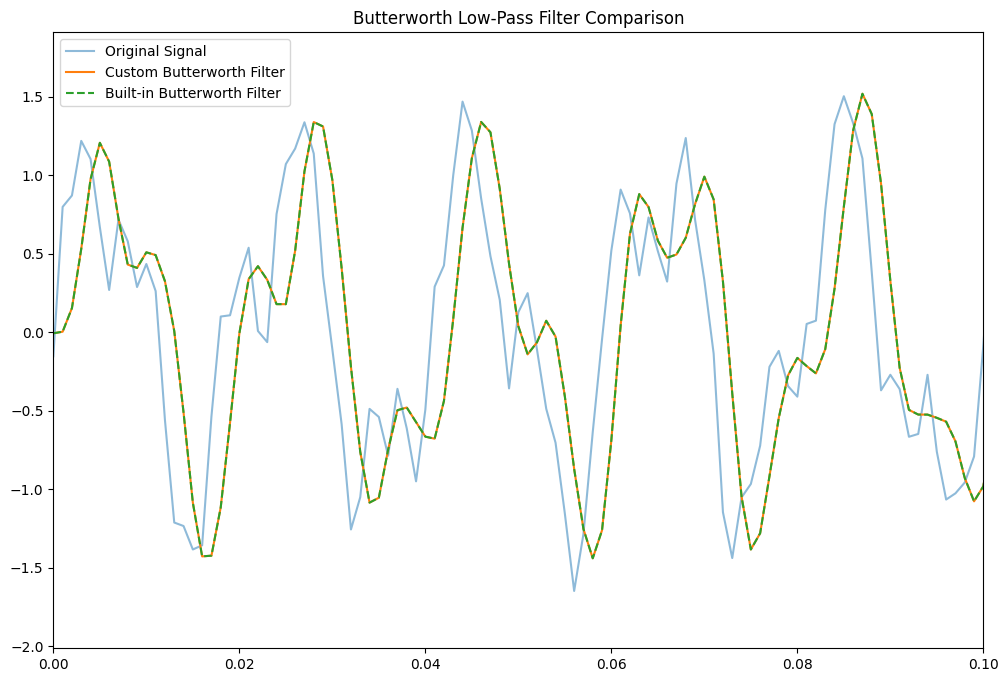

In [38]:
from scipy.signal import butter, lfilter

fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)

x = np.sin(2* np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t) + 0.2 * np.sin(2 * np.pi * 300 * t)
x += 0.1 * np.random.randn(len(t))

cutoff = 200
order = 4

b_custom, a_custom = butterworth_coeffs(cutoff, fs, order)

y_custom = apply_filter(b_custom, a_custom, x)

b_builtin, a_builtin = butter(order, cutoff, fs=fs, btype='low')
y_builtin = lfilter(b_builtin, a_builtin, x)

plt.figure(figsize=(12, 8))
plt.plot(t, x, label='Original Signal', alpha=0.5)
plt.plot(t, y_custom, label='Custom Butterworth Filter')
plt.plot(t, y_builtin, label='Built-in Butterworth Filter', linestyle='--')
plt.xlim(0, 0.1)
plt.legend()
plt.title("Butterworth Low-Pass Filter Comparison")
plt.show()

# Module 2

## Lecture 1

> <span style="color:red">**TODO**</span>: Explore ["Confidence intervals for evaluation in machine learning"](https://github.com/luferrer/ConfidenceIntervals/tree/main)

## Lecture 4

### **1**

> <font style="color:red">**TODO**</font>: Implement "UniversalSlicer", which will be able to cut/pad waves to pre-defined length and batch them. Implement different cutting/padding policies, for example, right/left pad, cut to fixed length or by silence regions (2+ points).

In [ ]:
import torchaudio
from typing import List

class UniversalSlicer:
    def __init__(self, sampling_rate: int, 
                       target_length: int = -1, 
                       padding: str = 'both',
                       cut_mode: str = 'both',
                       cut_silence: bool = False,
                       interval_factor: int = 50,
                       silence_threshold: float = 1e-2):
        """
            mode = left, right or both
        """
        self.__target_length = target_length
        self.__sampling_rate = sampling_rate
        self.__padding = padding
        self.__cut_mode = cut_mode
        self.__cut_silence = cut_silence
        self.__silence_thresh = silence_threshold
        self.__interval_factor = interval_factor


    def silent(self, wave: np.ndarray):
        mask = wave > self.__silence_thresh
        indices = np.where(mask.astype(int))[0]

        if len(indices) == 0:
            return []

        gaps = np.diff(indices) > 1
        split_points = np.where(gaps)[0] + 1

        segments = np.split(indices, split_points)

        intervals = [(seg[0], seg[-1] + 1) for seg in segments if len(seg) > 0]
        return intervals


    def merge_intervals(self, intervals, n):
        if not intervals:
            return []

        intervals.sort()
        merged = [intervals[0]]

        for start, end in intervals[1:]:
            prev_start, prev_end = merged[-1]

            if start - prev_end < n:
                merged[-1] = (prev_start, max(prev_end, end))
            else:
                merged.append((start, end))

        filtered = [(s, e) for (s, e) in merged if (e - s) >= n]
        return filtered


    def padding(self, wave: np.ndarray, target_size: int, mode: str = "both"):
        if len(wave) > target_size:
            raise ValueError("Padded audio is bigger than target")
        padding_size = target_size - len(wave)

        if mode == "both":
            left = np.zeros(padding_size // 2)
            right = np.zeros(padding_size // 2 + padding_size % 2)
            return np.concat([left, wave, right])
        elif mode == "left":
            return np.concatenate([np.zeros(padding_size), wave])
        elif mode == "right":
            return np.concatenate([wave, np.zeros(padding_size)])
        else:
            raise ValueError("Incorrect mode")

        
    def cut_silence(self, wave: np.ndarray):
        intervals = self.silent(wave)
        merged_intervals = self.merge_intervals(intervals, self.__sampling_rate // self.__interval_factor)
        if not merged_intervals:
            return np.array([])

        merged_audio = wave[merged_intervals[0][0]:merged_intervals[0][1] + 1]
        for i in range(1, len(merged_intervals)):
            merged_audio = np.concatenate([merged_audio, wave[merged_intervals[i][0]:merged_intervals[i][1] + 1]])
        return merged_audio


    def cut(self, wave: np.ndarray, target_size: int, mode: str = "both"):
        if target_size > len(wave):
            raise ValueError("Cutting audio is smaller than target")
        cutting_size = len(wave) - target_size

        if mode == "both":
            left = cutting_size // 2
            right = cutting_size // 2 + cutting_size % 2
            return wave[left:-right]
        elif mode == "left":
            return wave[cutting_size:]
        elif mode == "right":
            return wave[:-cutting_size]
        else:
            raise ValueError("Incorrect mode")


    def process(self, wave: np.ndarray):
        if self.__cut_silence:
            wave = self.cut_silence(wave)
        if self.__target_length == -1:
            return wave

        if self.__target_length < len(wave):
            wave = self.cut(wave, self.__target_length, self.__cut_mode)
        else:
            wave = self.padding(wave, self.__target_length, self.__padding)
        return wave
    
    
    def process_batch(self, waves: List[np.ndarray]):
        processed_waves = []
        for wave in waves:
            processed_waves.append(self.process(wave))
        return np.stack(processed_waves)


def plot_audio_comparison(original: np.ndarray, processed: np.ndarray, sr: int, title: str = "Audio Comparison"):
    time_orig = np.arange(len(original)) / sr
    time_proc = np.arange(len(processed)) / sr

    print(f"Original length: {len(original)} samples ({len(original)/sr:.2f} s)")
    print(f"Processed length: {len(processed)} samples ({len(processed)/sr:.2f} s)")

    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=False)
    fig.suptitle(title)

    axs[0].plot(time_orig, original, label="Original", color='blue')
    axs[0].set_title("Original Waveform")
    axs[0].set_ylabel("Amplitude")

    axs[1].plot(time_proc, processed, label="Processed", color='orange')
    axs[1].set_title("Processed Waveform")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlabel("Time [s]")

    plt.tight_layout()
    plt.show()

#### **Cut**

Original length: 217280 samples (13.58 s)
Processed length: 180000 samples (11.25 s)


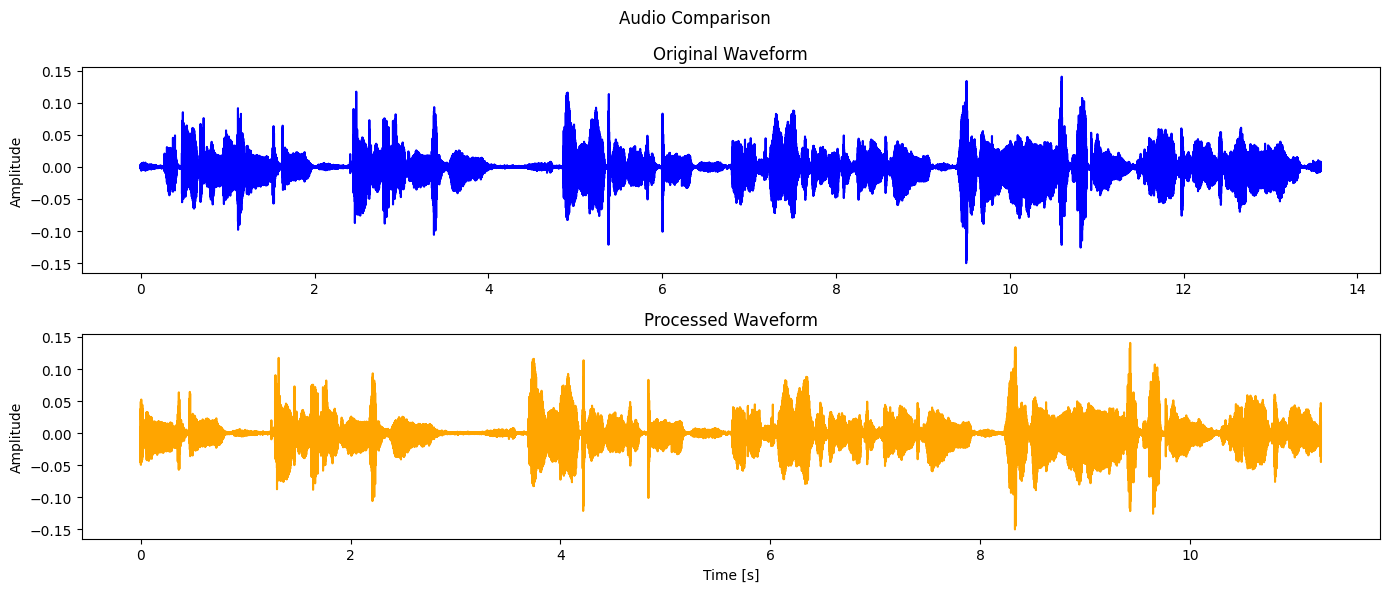

In [176]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 180000, cut_mode="both")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 180000 samples (11.25 s)


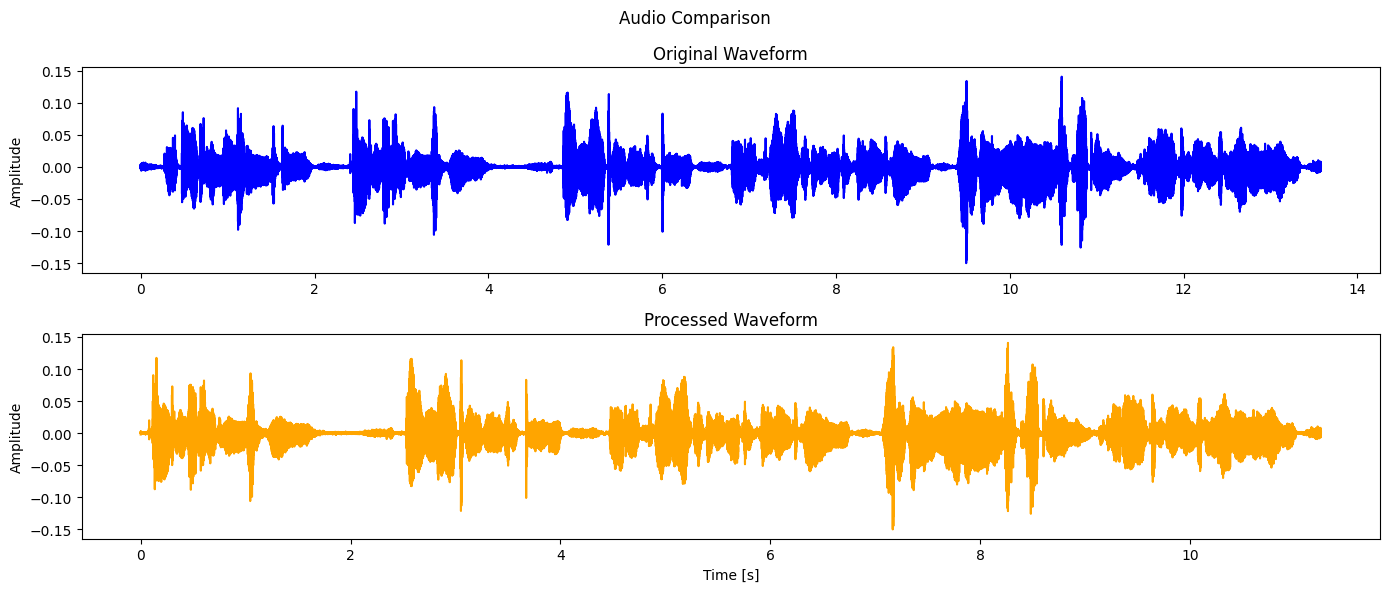

In [156]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 180000, cut_mode="left")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 180000 samples (11.25 s)


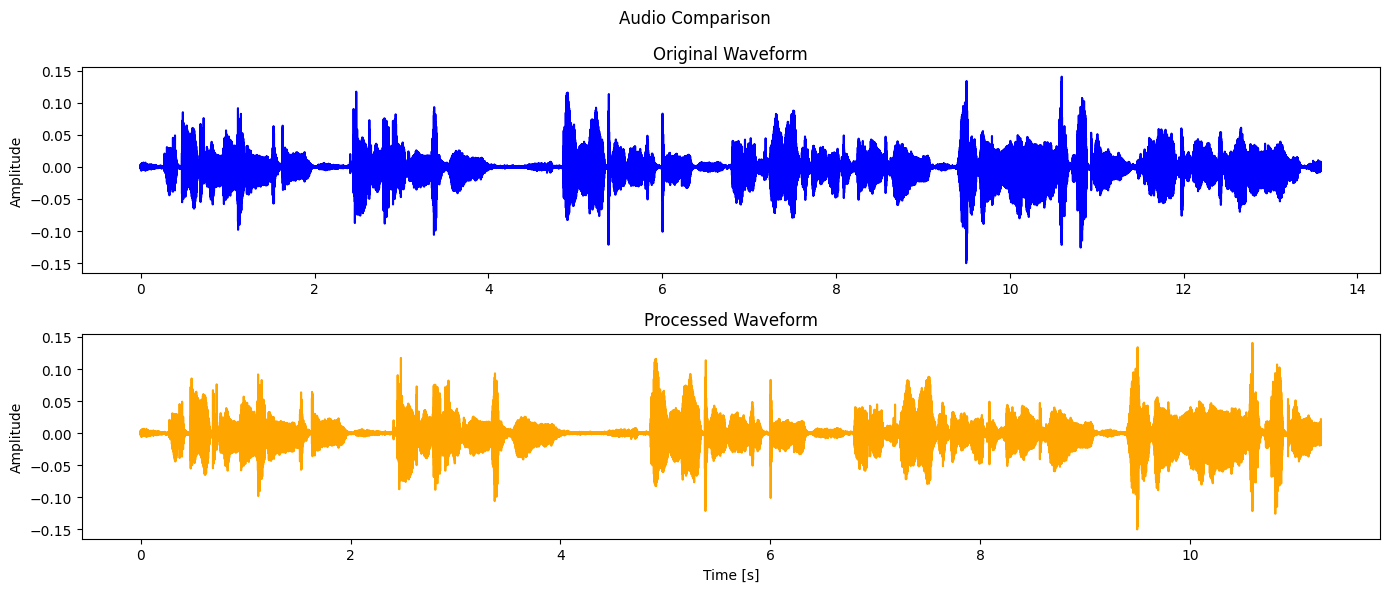

In [159]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 180000, cut_mode="right")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 151339 samples (9.46 s)


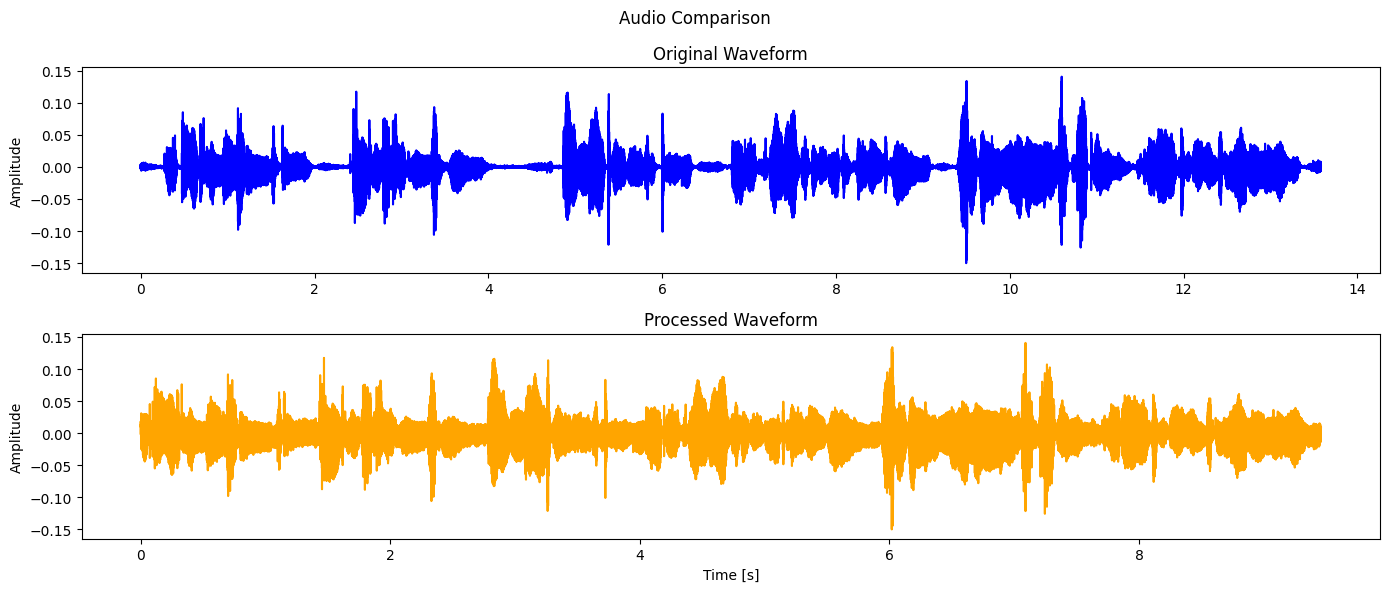

In [165]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, -1, cut_silence=True)
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

#### Padding

Original length: 217280 samples (13.58 s)
Processed length: 250000 samples (15.62 s)


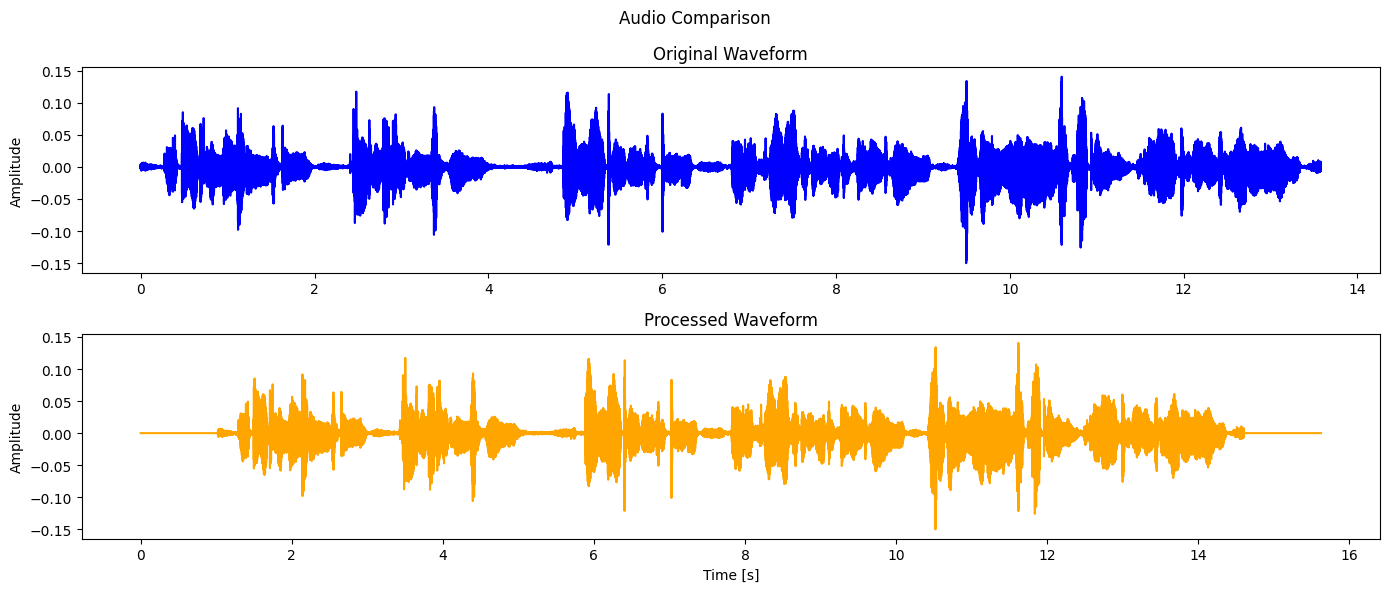

In [152]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 250000, padding="both")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 250000 samples (15.62 s)


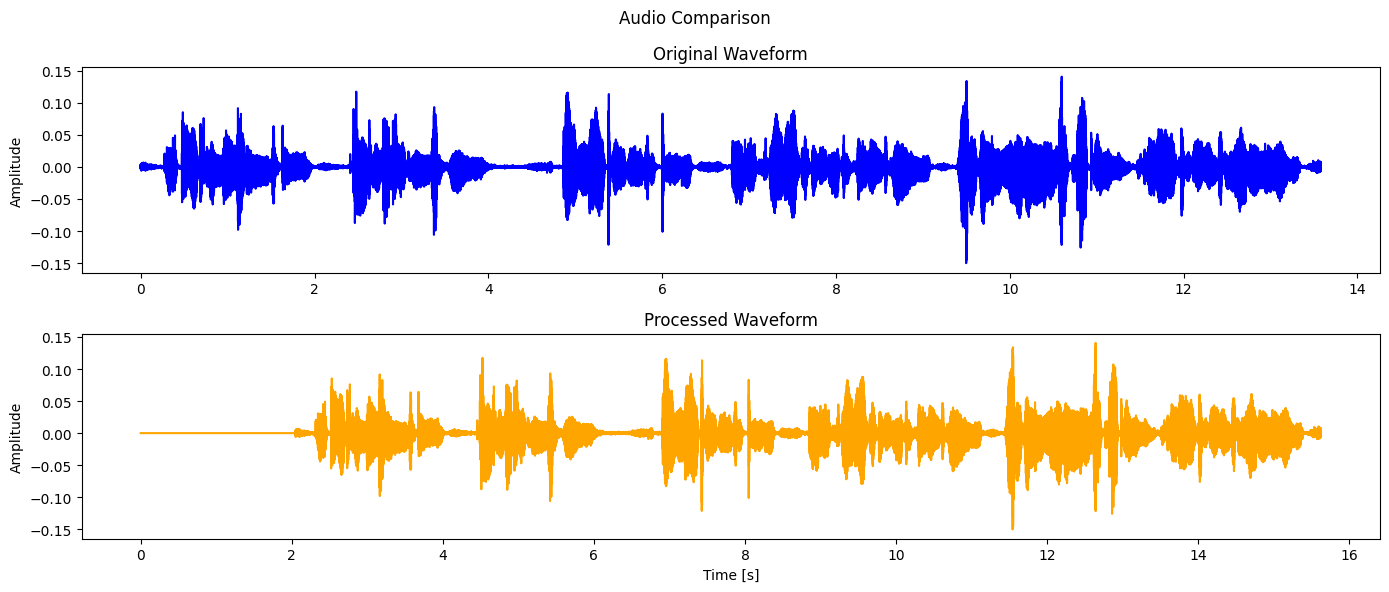

In [147]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 250000, padding="left")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

Original length: 217280 samples (13.58 s)
Processed length: 250000 samples (15.62 s)


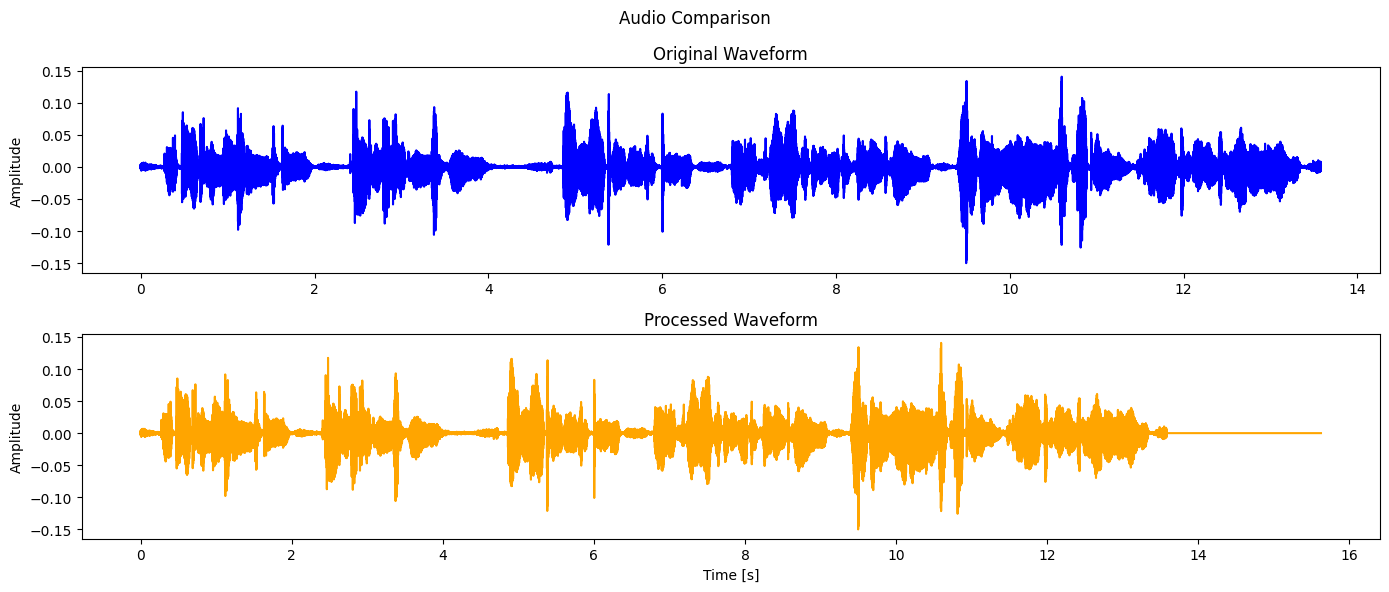

In [148]:
audio, sr = load_flac("./audio/audio8.flac")
slicer = UniversalSlicer(sr, 250000, padding="right")
audio_processed = slicer.process(audio)

plot_audio_comparison(audio, audio_processed, sr)

#### Batched processing

In [164]:
waveforms = []
min_len = float("inf")
max_len = 0
sr = 16000

audio_paths = [f"./audio/audio{i}.flac" for i in range(1, 9)]

for path in audio_paths:
    waveform, sample_rate = load_flac(path)
    if sample_rate != sr:
        waveform = torchaudio.transforms.Resample(sample_rate, sr)(waveform)
    max_len = max(max_len, waveform.shape[0])
    min_len = min(min_len, waveform.shape[0])
    waveforms.append(waveform)

##### Min size

In [ ]:
slicer = UniversalSlicer(sr, min_len, padding="both", cut_mode="both", cut_silence=True)
audio_processed = slicer.process_batch(waveforms)

audio_processed.shape

Original length: 33440 samples (2.09 s)
Processed length: 33440 samples (2.09 s)


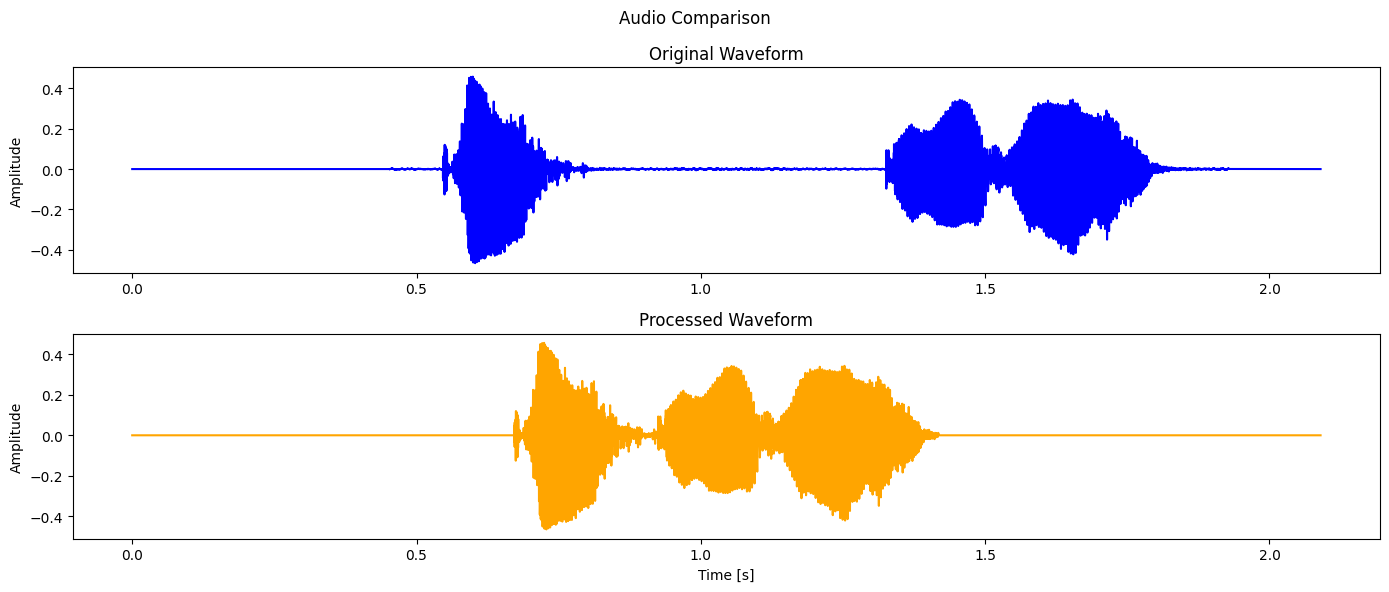

Original length: 63840 samples (3.99 s)
Processed length: 33440 samples (2.09 s)


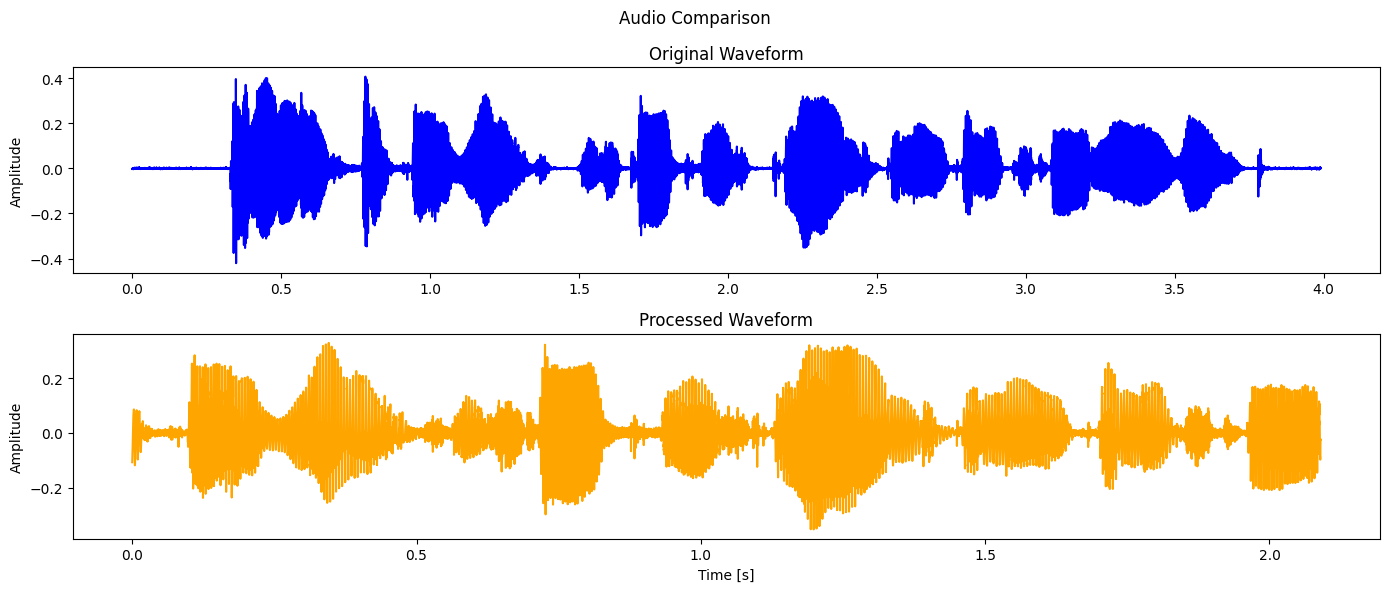

Original length: 70400 samples (4.40 s)
Processed length: 33440 samples (2.09 s)


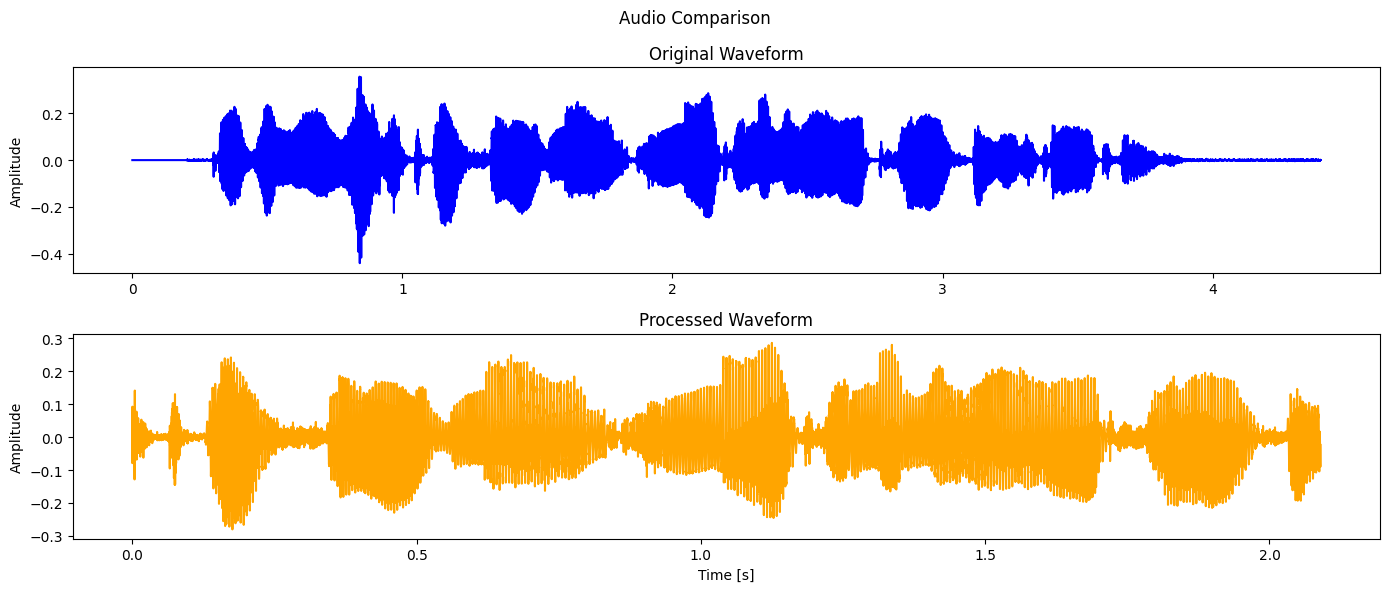

Original length: 237600 samples (14.85 s)
Processed length: 33440 samples (2.09 s)


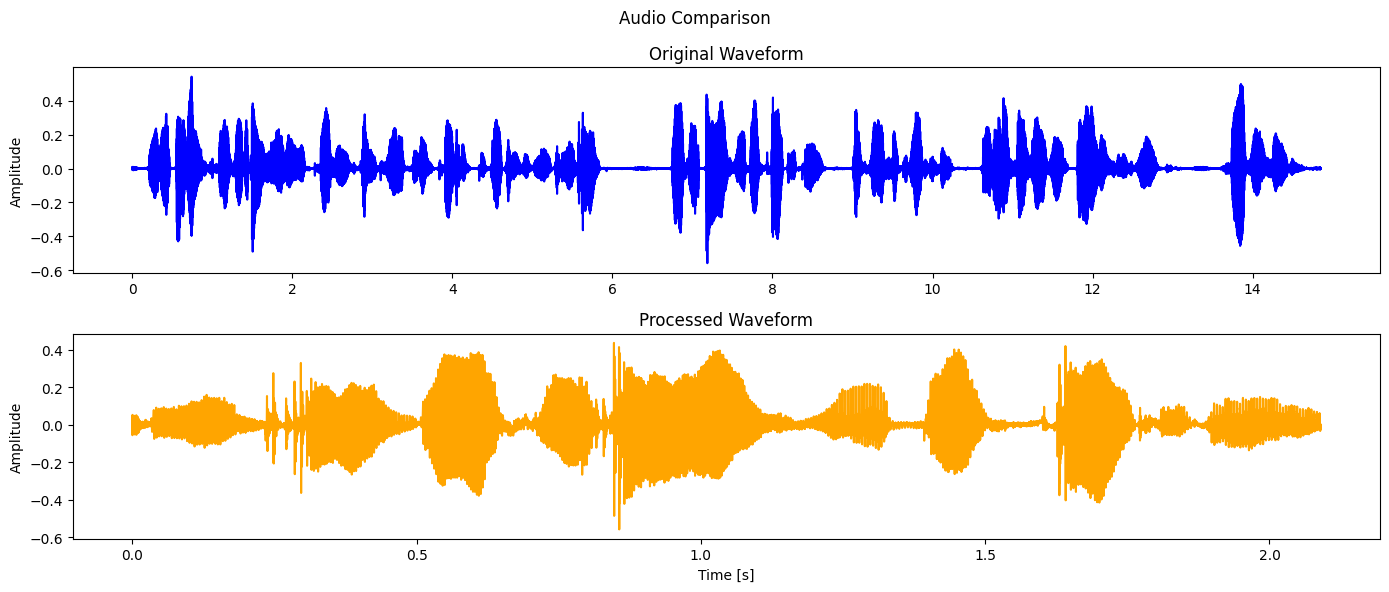

Original length: 249040 samples (15.56 s)
Processed length: 33440 samples (2.09 s)


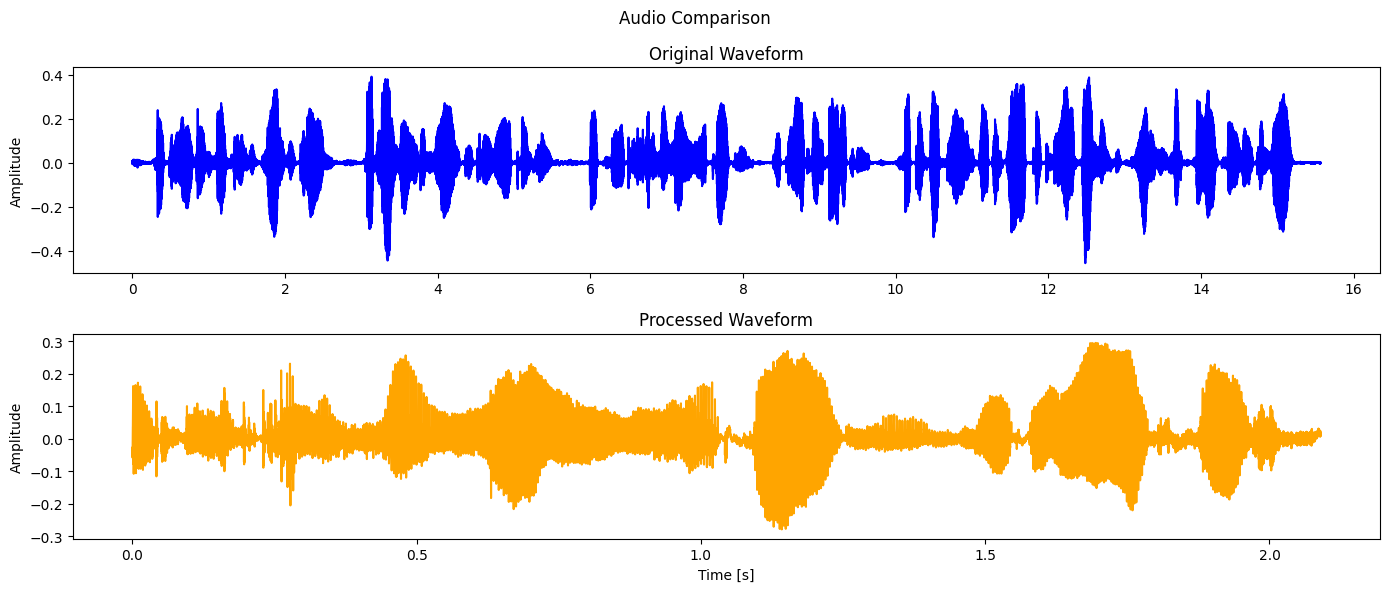

Original length: 235679 samples (14.73 s)
Processed length: 33440 samples (2.09 s)


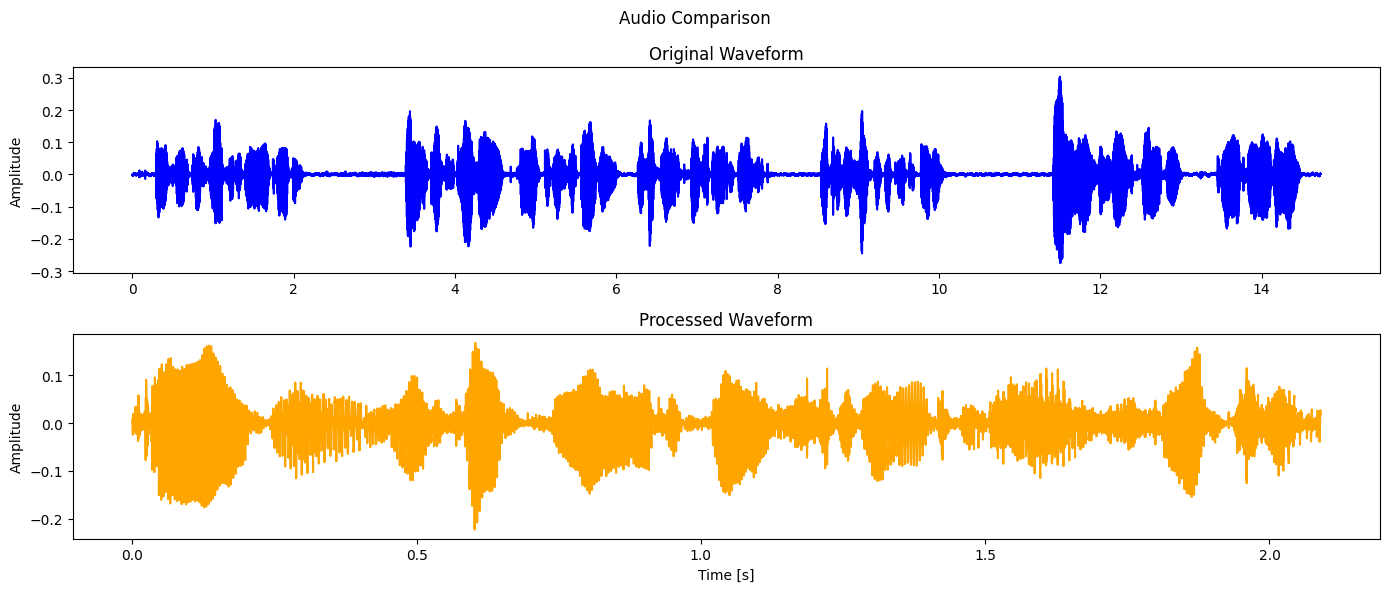

Original length: 192560 samples (12.04 s)
Processed length: 33440 samples (2.09 s)


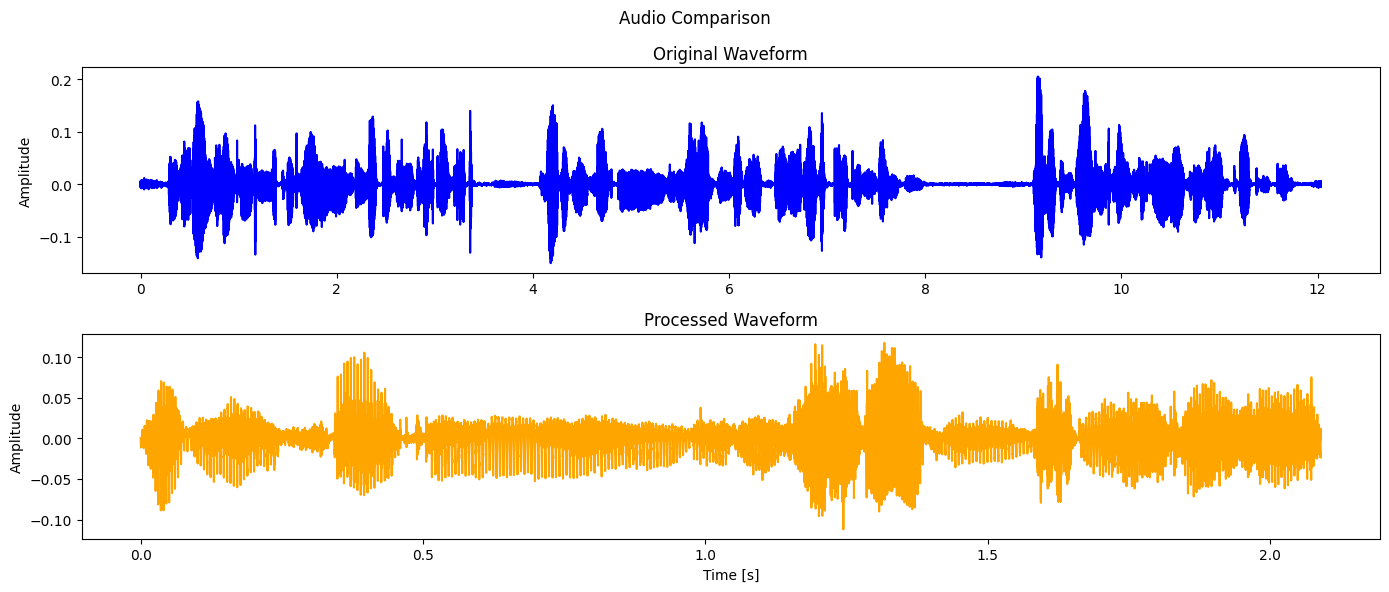

Original length: 217280 samples (13.58 s)
Processed length: 33440 samples (2.09 s)


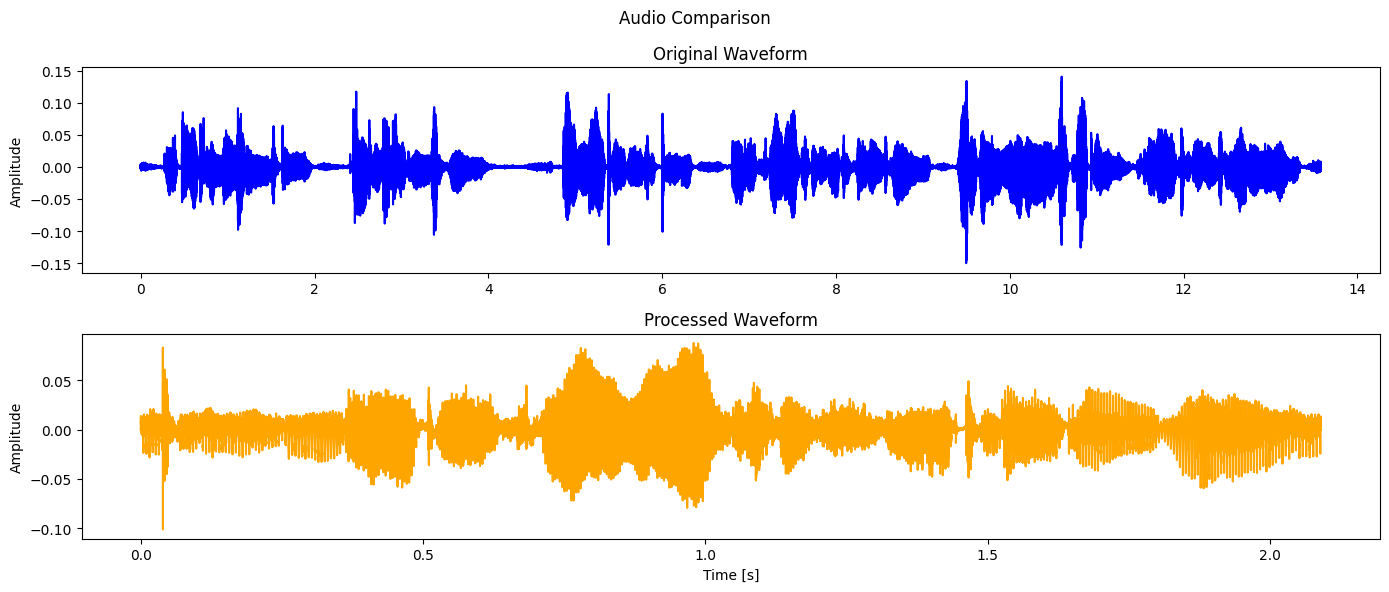

In [170]:
for waveform, processed_waveform in zip(waveforms, audio_processed):
    plot_audio_comparison(waveform, processed_waveform, sr)

##### Max size

In [171]:
slicer = UniversalSlicer(sr, max_len, padding="both", cut_mode="both", cut_silence=True)
audio_processed = slicer.process_batch(waveforms)

audio_processed.shape

(8, 249040)

Original length: 33440 samples (2.09 s)
Processed length: 249040 samples (15.56 s)


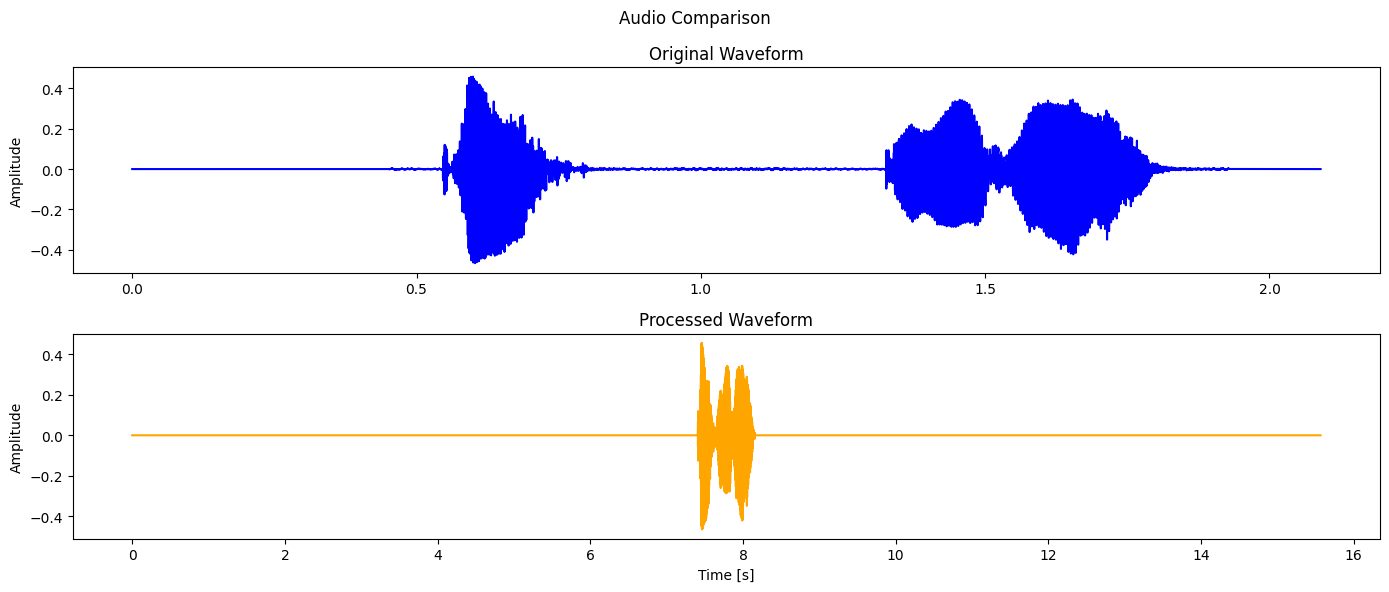

Original length: 63840 samples (3.99 s)
Processed length: 249040 samples (15.56 s)


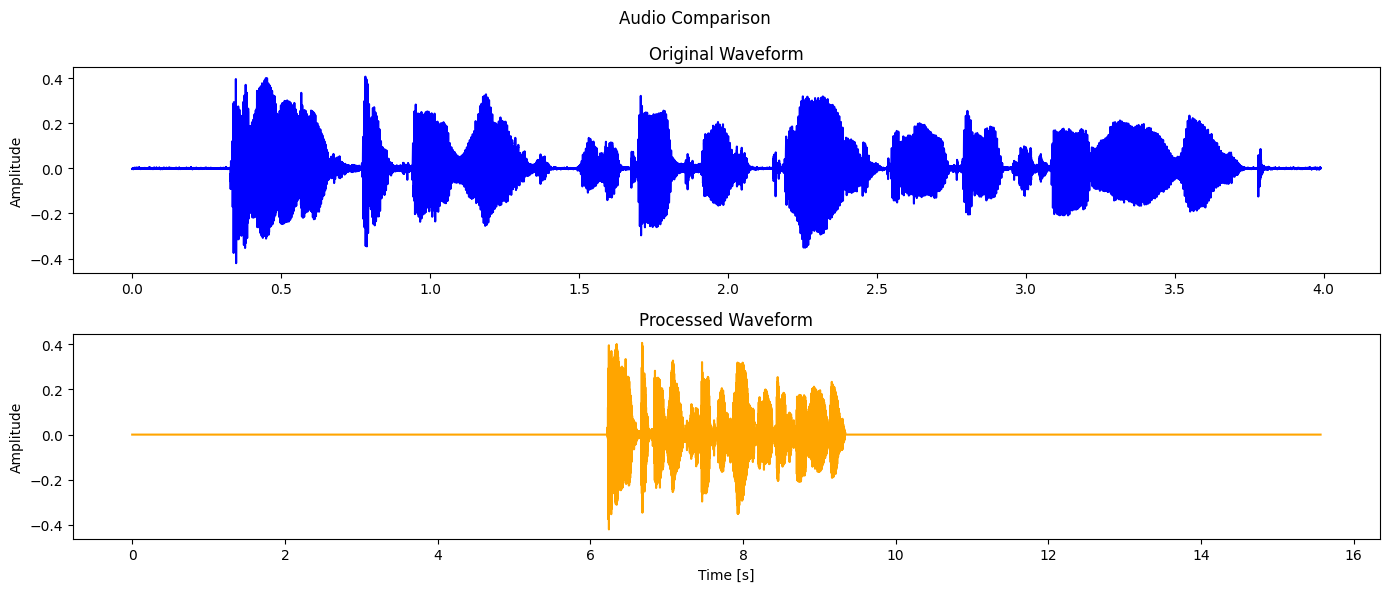

Original length: 70400 samples (4.40 s)
Processed length: 249040 samples (15.56 s)


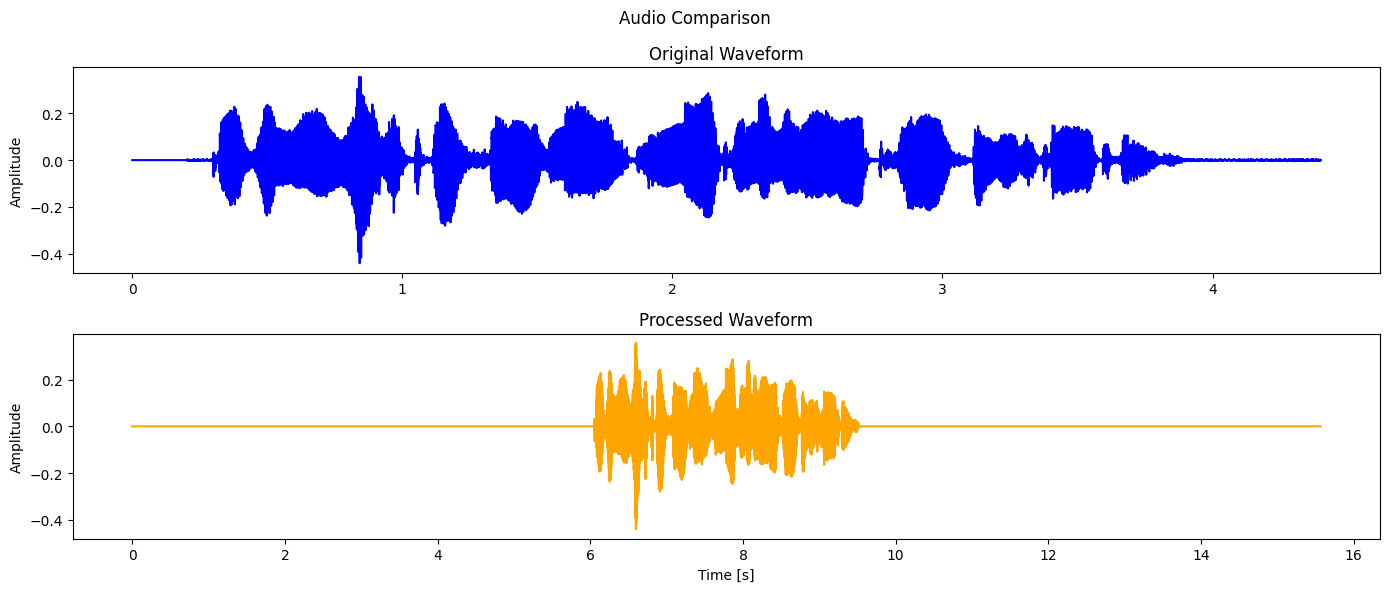

Original length: 237600 samples (14.85 s)
Processed length: 249040 samples (15.56 s)


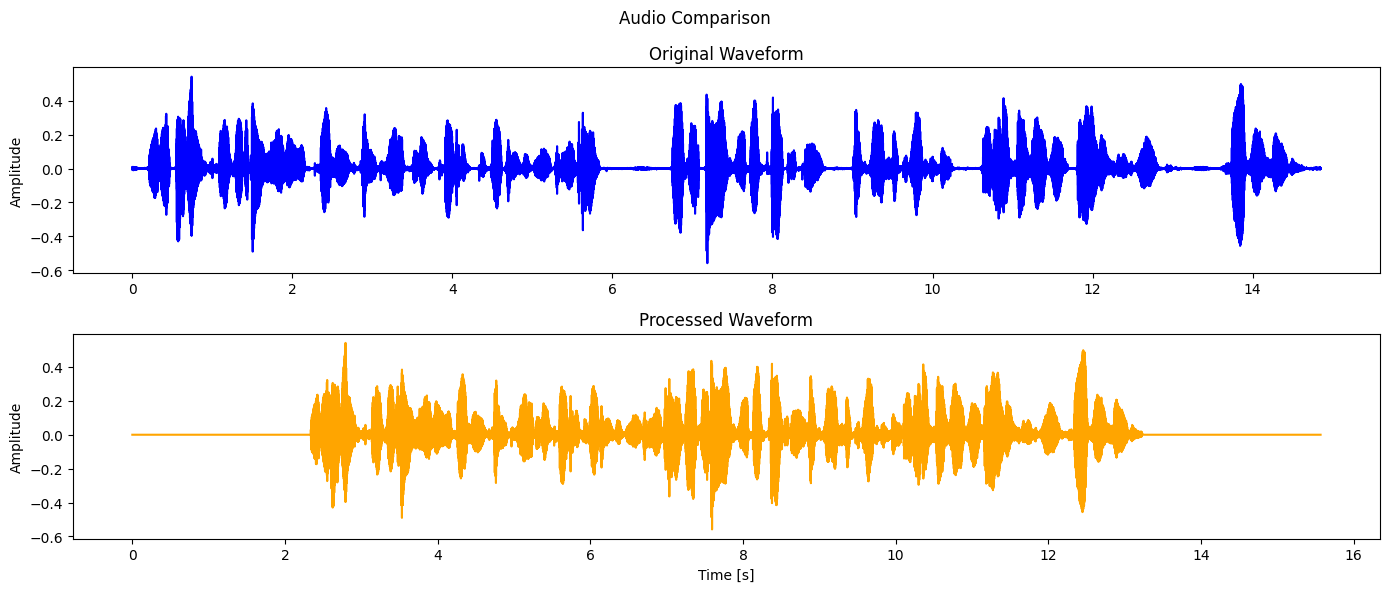

Original length: 249040 samples (15.56 s)
Processed length: 249040 samples (15.56 s)


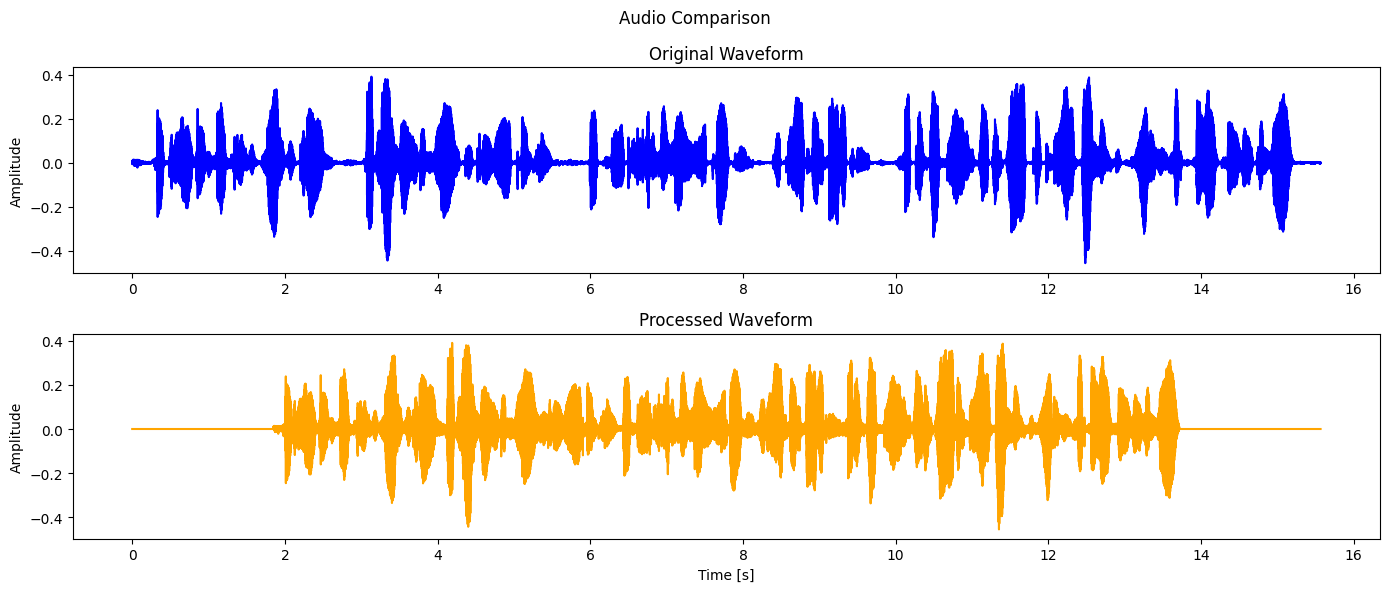

Original length: 235679 samples (14.73 s)
Processed length: 249040 samples (15.56 s)


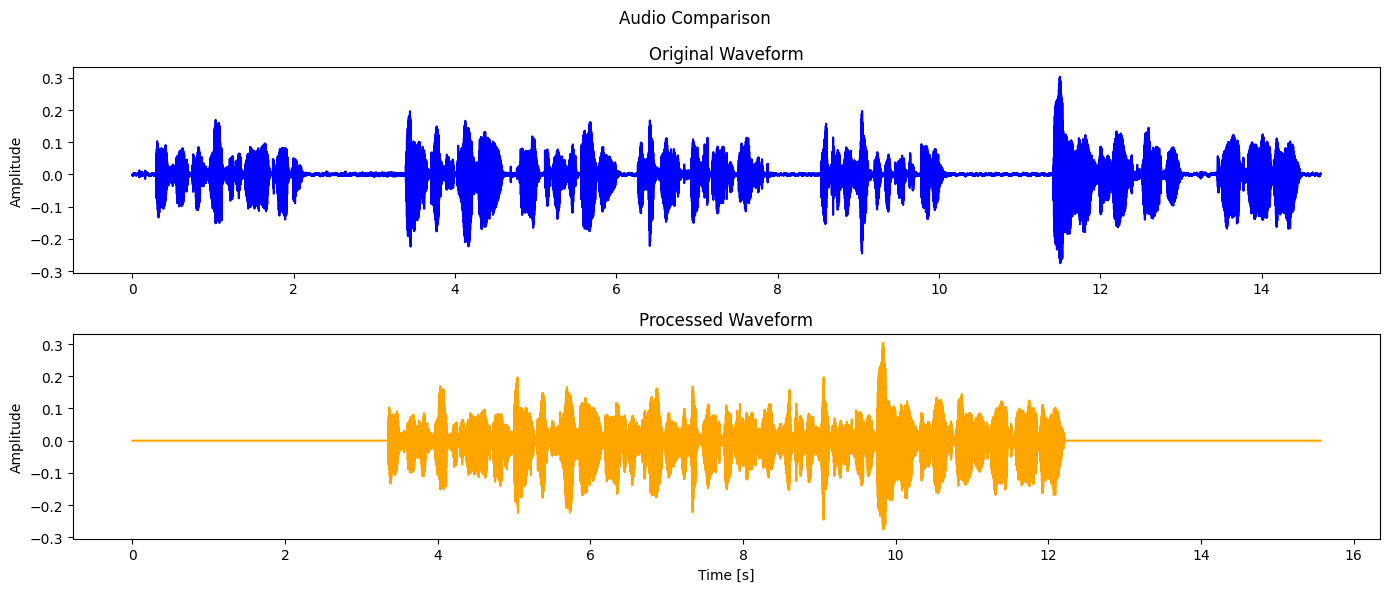

Original length: 192560 samples (12.04 s)
Processed length: 249040 samples (15.56 s)


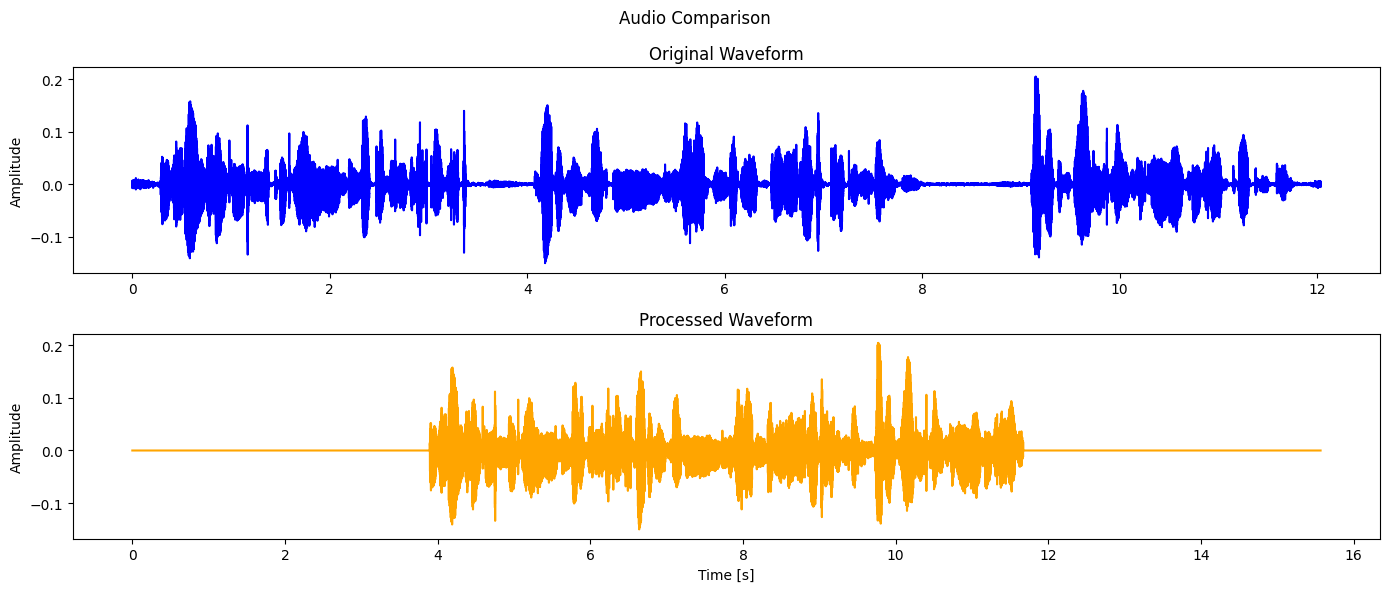

Original length: 217280 samples (13.58 s)
Processed length: 249040 samples (15.56 s)


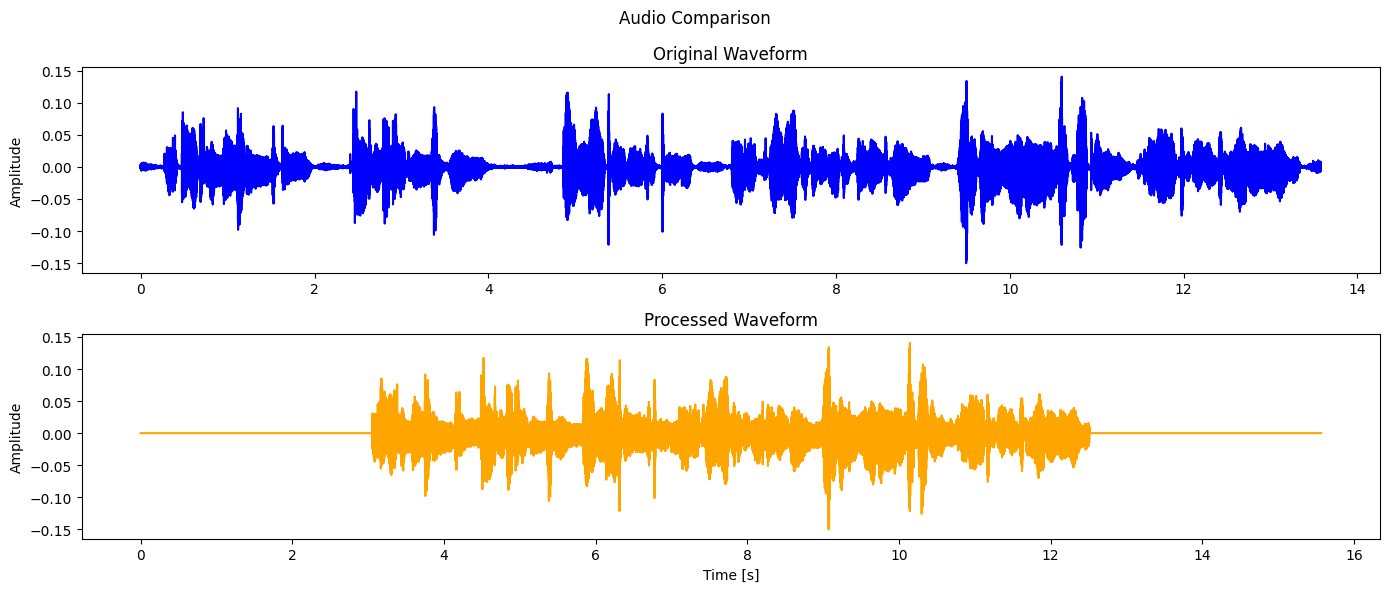

In [172]:
for waveform, processed_waveform in zip(waveforms, audio_processed):
    plot_audio_comparison(waveform, processed_waveform, sr)

##### Median

In [173]:
slicer = UniversalSlicer(sr, (max_len + min_len) // 2, padding="both", cut_mode="both", cut_silence=True)
audio_processed = slicer.process_batch(waveforms)

audio_processed.shape

(8, 141240)

Original length: 33440 samples (2.09 s)
Processed length: 141240 samples (8.83 s)


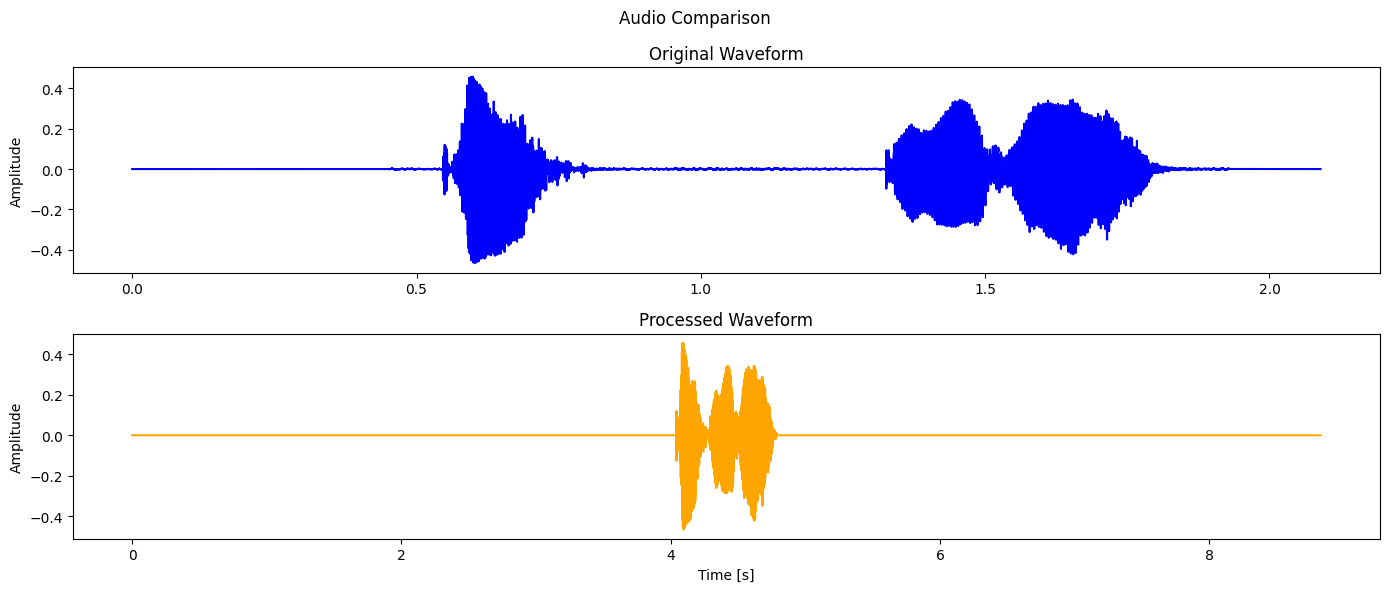

Original length: 63840 samples (3.99 s)
Processed length: 141240 samples (8.83 s)


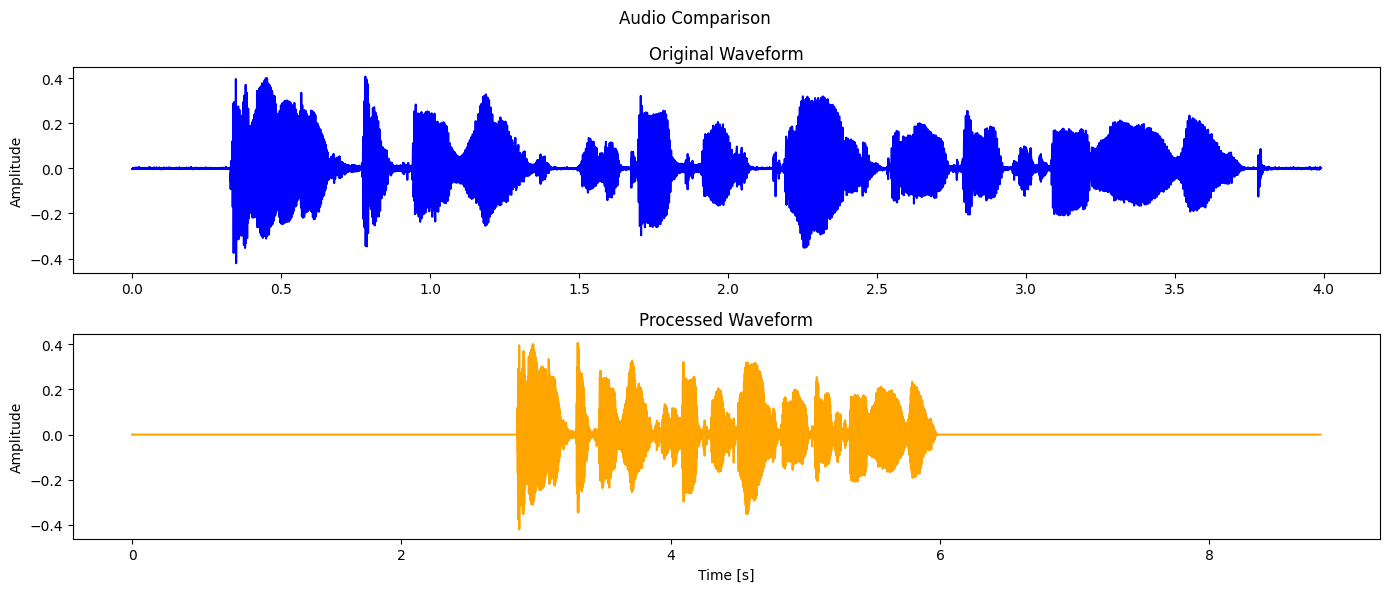

Original length: 70400 samples (4.40 s)
Processed length: 141240 samples (8.83 s)


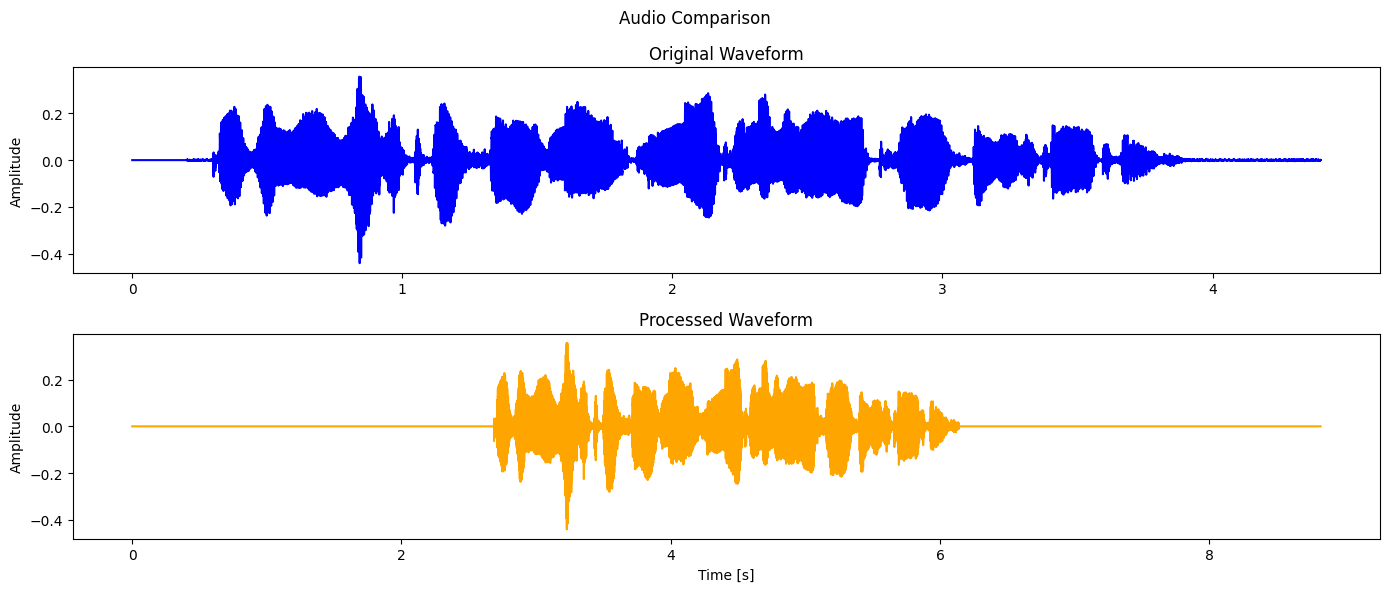

Original length: 237600 samples (14.85 s)
Processed length: 141240 samples (8.83 s)


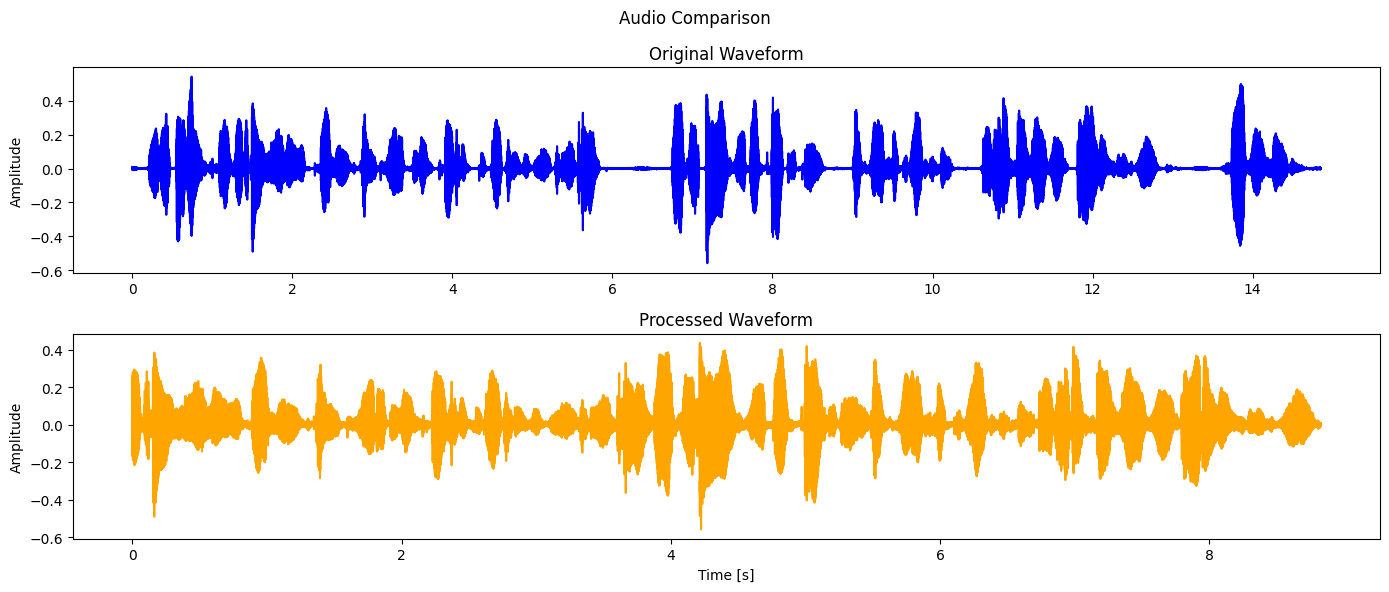

Original length: 249040 samples (15.56 s)
Processed length: 141240 samples (8.83 s)


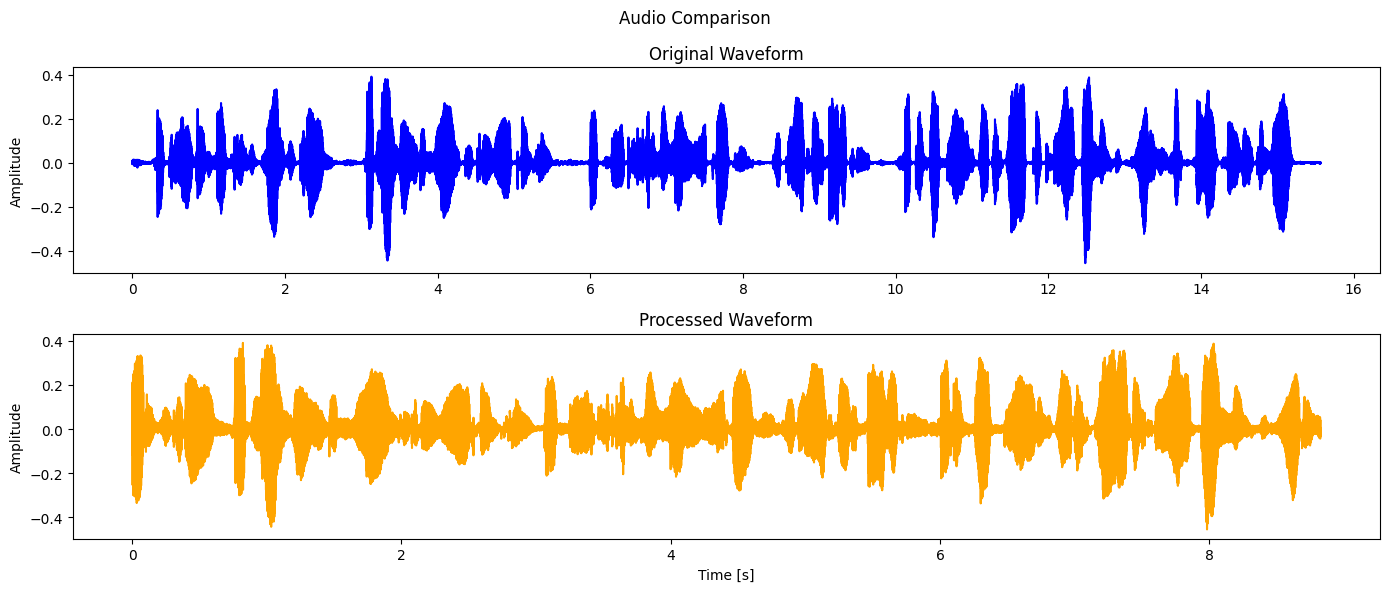

Original length: 235679 samples (14.73 s)
Processed length: 141240 samples (8.83 s)


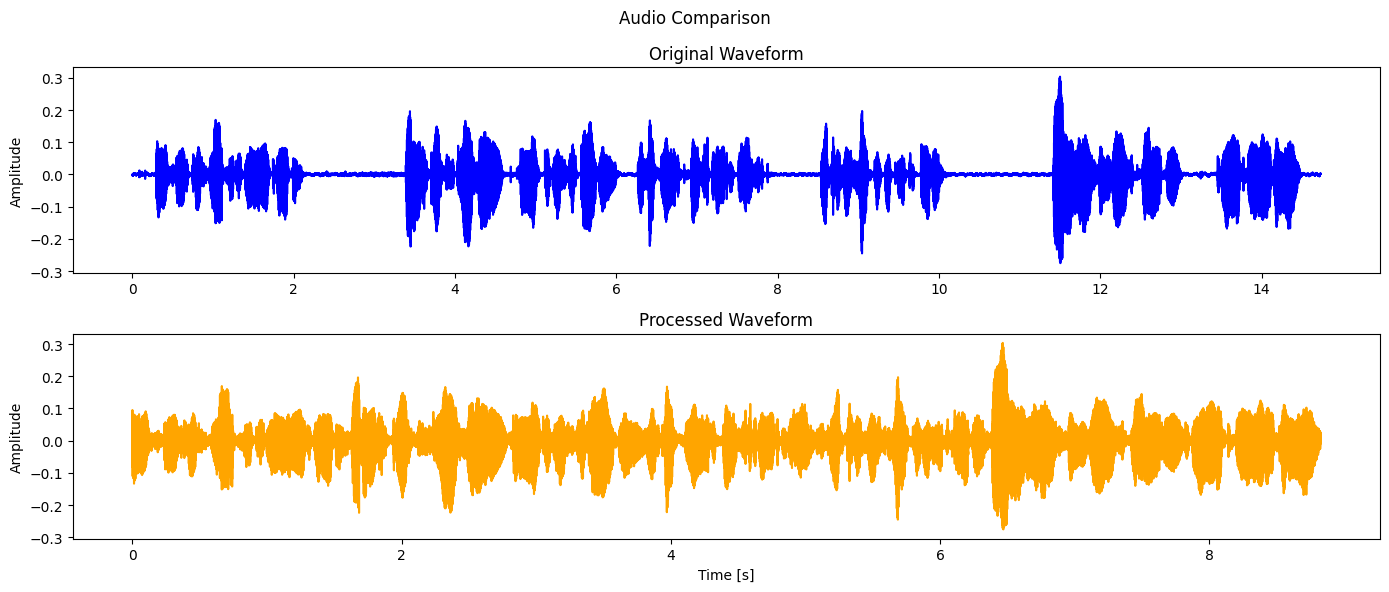

Original length: 192560 samples (12.04 s)
Processed length: 141240 samples (8.83 s)


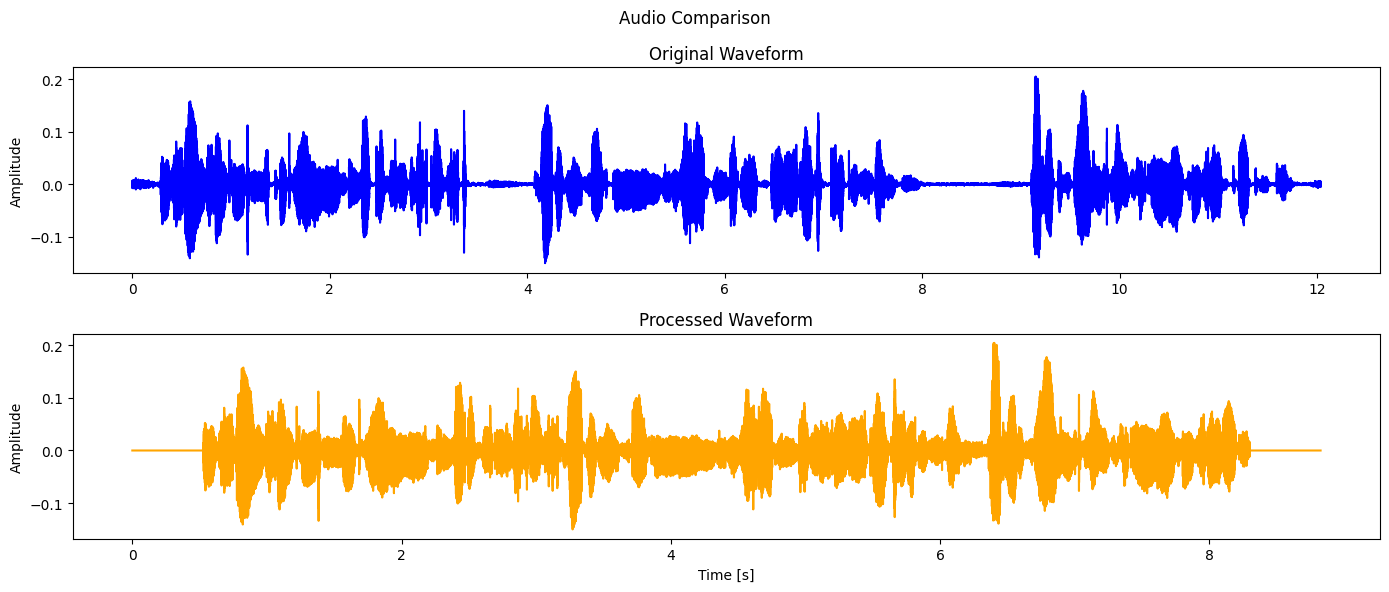

Original length: 217280 samples (13.58 s)
Processed length: 141240 samples (8.83 s)


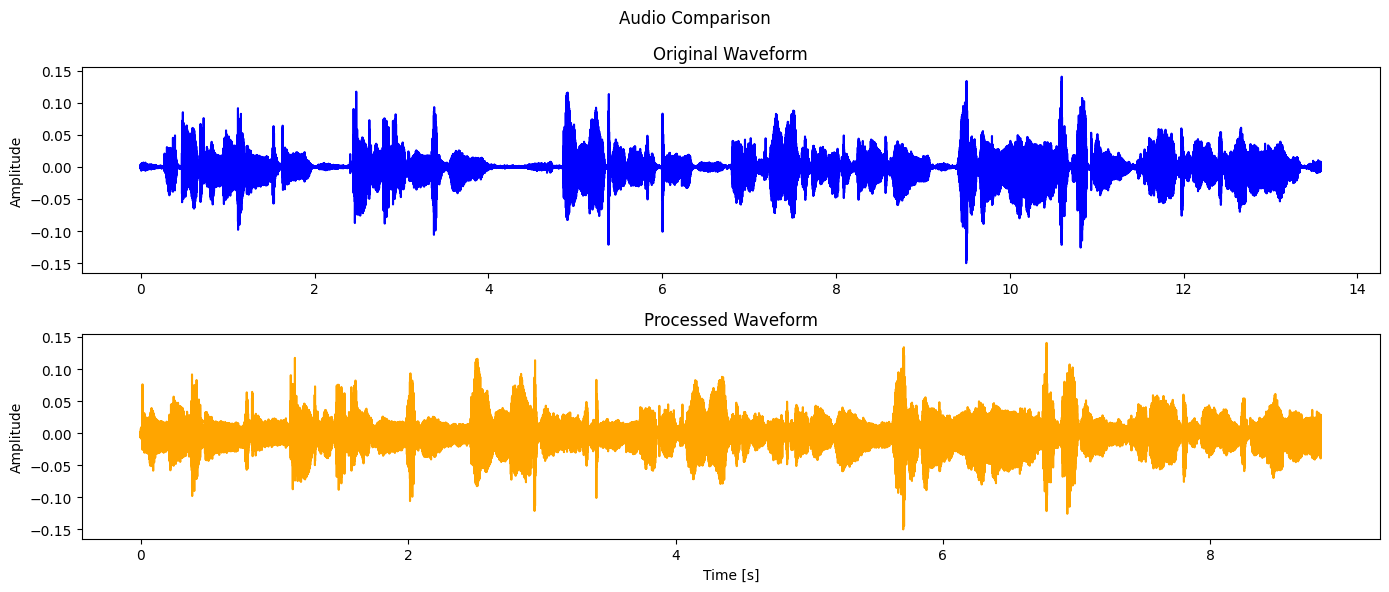

In [174]:
for waveform, processed_waveform in zip(waveforms, audio_processed):
    plot_audio_comparison(waveform, processed_waveform, sr)

### **2**

In [22]:
import torch
import torch.nn as nn


class Audio2SpecPad(nn.Module):
    def __init__(
        self,
        hop_size=512
    ):
        super().__init__()
        self.maxpool = nn.MaxPool1d(
            kernel_size=hop_size,
            stride=hop_size
        )
    
    def forward(self, audio_pads, time_max_length):
        spec_pads = self.maxpool(audio_pads.unsqueeze(1)).squeeze(1)
        pad = torch.ones(spec_pads.shape[0], time_max_length - spec_pads.shape[-1])
        spec_pads = torch.cat((pad, spec_pads), axis=1)
        return spec_pads
        
audio2spec_pad_layer = Audio2SpecPad()

> <font style="color:red">**TODO**</font>: Rewrite `Audio2SpecPad` and get rid of "hacky pad" (1 point)

In [47]:
class Audio2SpecPadUpdated(nn.Module):
    def __init__(
        self,
        hop_size=512
    ):
        super().__init__()
        self.maxpool = nn.MaxPool1d(
            kernel_size=hop_size,
            stride=hop_size
        )
    
    def forward(self, audio_pads, time_max_length):
        spec_pads = self.maxpool(audio_pads.unsqueeze(1)).squeeze(1)
    
        pad_length = time_max_length - spec_pads.shape[-1]
        if pad_length > 0:
            spec_pads = torch.nn.functional.pad(spec_pads, (0, pad_length), mode='constant', value=0)
        return spec_pads
        
audio2spec_pad_layer = Audio2SpecPadUpdated()

### **3**

> <font style="color:red">**TODO**</font>: Explore [Wav2Vec2FeatureExtractor](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2FeatureExtractor). Can we rewrite it, so it takes on input batched torch.Tensor ? (1 point)

In [3]:
import torch
import torchaudio
import numpy as np
from transformers import Wav2Vec2FeatureExtractor

class BatchedWav2Vec2FeatureExtractor(torch.nn.Module):
    def __init__(self, sampling_rate=16000, normalize=True):
        super().__init__()
        self.sampling_rate = sampling_rate
        self.normalize = normalize
        
    def forward(self, audio: torch.Tensor, attention_mask: torch.Tensor = None) -> torch.Tensor:
        if self.normalize:
            mean = audio.mean(dim=1, keepdim=True)
            std = audio.std(dim=1, keepdim=True, unbiased=False) + 1e-7
            audio = (audio - mean) / std
        if attention_mask is not None:
            audio = audio * attention_mask
        return audio

**Note**: before testing please run all cells in Module2 Lecture 4 Task 1

In [9]:
waveforms = []
max_len = 0
sr = 16000

audio_paths = [f"./audio/audio{i}.flac" for i in range(1, 9)]

for path in audio_paths:
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != sr:
        waveform = torchaudio.transforms.Resample(sample_rate, sr)(waveform)
    max_len = max(max_len, waveform.shape[1])
    waveforms.append(waveform[0].numpy())
    
slicer = UniversalSlicer(sr, max_len, padding="right")
waveforms = slicer.process_batch(waveforms)
    
batch = torch.tensor(waveforms)
print(f"Batch shape: {batch.shape}")

Batch shape: torch.Size([8, 249040])


In [8]:
batch_extractor = BatchedWav2Vec2FeatureExtractor(sampling_rate=sr, normalize=True)
hf_extractor = Wav2Vec2FeatureExtractor(
    feature_size=2,
    sampling_rate=sr,
    normalization=True,
)

batch_out = batch_extractor(batch)
print(f"Batch output shape: {batch_out.shape}")

for i, path in enumerate(audio_paths):
    hf_out = hf_extractor(batch[i].numpy(), sampling_rate=sr)["input_values"][0]
    diff = abs(batch_out[i].numpy() - hf_out)
    max_diff = diff.max().item()

    print(f"Max difference for {path}: {max_diff:.6f}")

Batch output shape: torch.Size([8, 249040])
Max difference for ./audio/audio1.flac: 0.000684
Max difference for ./audio/audio2.flac: 0.000236
Max difference for ./audio/audio3.flac: 0.000383
Max difference for ./audio/audio4.flac: 0.000127
Max difference for ./audio/audio5.flac: 0.000134
Max difference for ./audio/audio6.flac: 0.000428
Max difference for ./audio/audio7.flac: 0.002150
Max difference for ./audio/audio8.flac: 0.002771


### **4**

> <span style="color:red">**TODO**</span>: Explore [Wav2Vec2Model](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Model) docs and use `attention_mask` in order to optimize computations and unpad seuqnce in a bettter way (0.5 point).

In [80]:
from transformers import AutoProcessor, Wav2Vec2Model

DEVICE = "cuda"
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

/home/artur/files/Audio Processing/Audio_Processing_Labs/Additional/venv/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:61: FutureWarning: Loading a tokenizer inside Wav2Vec2Processor from a config that does not include a `tokenizer_class` attribute is deprecated and will be removed in v5. Please add `'tokenizer_class': 'Wav2Vec2CTCTokenizer'` attribute to either your `config.json` or `tokenizer_config.json` file to suppress this warning: 
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
waveforms = []
max_len = 0
sr = 16000

audio_paths = [f"./audio/audio{i}.flac" for i in range(1, 9)]

for path in audio_paths:
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != sr:
        waveform = torchaudio.transforms.Resample(sample_rate, sr)(waveform)
    max_len = max(max_len, waveform.shape[1])
    waveforms.append(waveform[0].numpy())

In [82]:
input_values = processor(
    waveforms,
    sampling_rate=sr,
    return_tensors="pt",
    padding=True,
    return_attention_mask=True
)

with torch.no_grad():
    model_output = model(
        input_values["input_values"].cuda(),
        attention_mask=input_values['attention_mask'].cuda()
    )

model_output = model_output.last_hidden_state.cpu()

In [83]:
audio2spec_pad_layer1 = Audio2SpecPad(hop_size=320 * 3)

computed_w2v_pad = audio2spec_pad_layer1(
    input_values['attention_mask'].to(dtype=torch.float64), 
    time_max_length=model_output.shape[1]
)

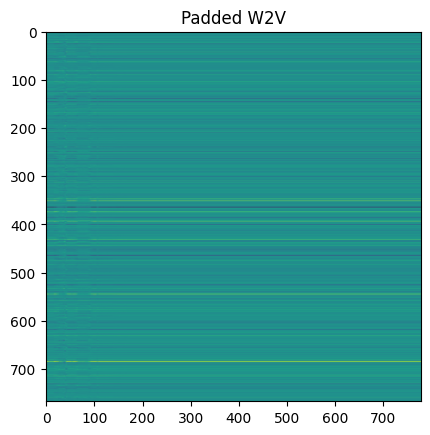

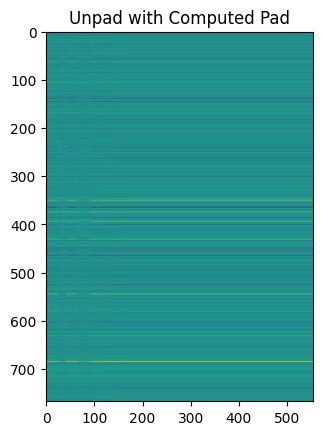

In [84]:
plt.title("Padded W2V")
plt.imshow(model_output[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(model_output[0][computed_w2v_pad[0]==1].T)
plt.show()

### **5**

> <font style="color:red">**TODO**</font>: Check how to normalize outputs of [HubertForCTC](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertForCTC). *Simply put, make them in a format we had for W2V.* (2 points)

In [93]:
from transformers import AutoProcessor, HubertForCTC

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(DEVICE)

In [144]:
waveform, sample_rate = torchaudio.load("./audio/audio7.flac")

inputs = processor(
    waveform,
    sampling_rate=sample_rate,
    return_tensors="pt",
    padding=True
)
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(inputs['input_values'][0], output_hidden_states=True)

    #Here is normalization
    hidden_states = outputs.hidden_states[-1]
    normalized_features = torch.nn.functional.normalize(hidden_states, p=2, dim=-1)
    logits = model.lm_head(normalized_features)

predicted_ids = torch.argmax(logits, dim=-1)
transcriptions = processor.batch_decode(predicted_ids)

In [145]:
print(transcriptions)
Audio(waveform.numpy(), rate=sample_rate)

["AND SAING SOMETHING TO HIS COMPANION WITH A LOOK OF UTTER DISGUST PROBABLY THOUGHT AMORY WHAT HE SAID WAS MY GOD AREN'T PEOPLE HORRIBLE NEVER BEFORE IN HIS LIFE HAD AMORY CONSIDERED POOR PEOPLE"]


### **6**

In [ ]:
import torch
import librosa
from tqdm import tqdm
from transformers import AutoFeatureExtractor, AutoModelForAudioXVector

class XVectorExtractor:
    def __init__(
        self,
        model_name,
        device="cpu",
        do_normalize=True
    ):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)
        self.do_normalize = do_normalize

    def extract_features(
        self,
        wave_pathes,
        sample_rate
    ):
        features = []
        for wave_path in tqdm(wave_pathes):
            wave, _ = librosa.load(wave_path, sr=sample_rate)
            inputs = self.feature_extractor([wave], sampling_rate=sample_rate, return_tensors="pt").input_values
            with torch.no_grad():
                embeddings = self.model(inputs.cuda()).embeddings
            if self.do_normalize:
                embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            embeddings = embeddings.cpu()
            features.append(embeddings)
        return torch.cat(features, dim=0)

> <font style="color:red">**TODO**</font>: Add batching (1 point).


### **7**

> <font style="color:red">**TODO**</font>: How to transform `Wav2Vec2Model` into `Wav2Vec2ForXVector` (0.5 point)?